# Ensemble Learning

The goal behind ensemble methods is to combine different classifiers into a  meta-classifier that has a better generalization performance than each individual classifier alone. For example, assuming that we collected predictions from 10 experts, ensemble methods would allow us to strategically combine these predictions by the 10 experts to come up with a prediction that is more accurate and robust than the predictions by each individual expert

In [1]:
from scipy.special import comb
import math

In [3]:
def ensemble_error(n_classifier,error):
    k_start=math.ceil(n_classifier/2)
    probs=[comb(n_classifier,k)*error**k*(1-error)**(n_classifier-k) for k in range(k_start,n_classifier+1)]
    return sum(probs)

In [4]:
ensemble_error(n_classifier=11,error=0.25)

0.03432750701904297

After we've implemented the ensemble_error function, we can compute the ensemble error rates for a range of different base errors from 0.0 to 1.0 to visualize the relationship between ensemble and base errors in a line graph

In [5]:
import numpy as np
error_range=np.arange(0,1.01,0.01)
ens_errors=[ensemble_error(n_classifier=11,error=error) for error in error_range]

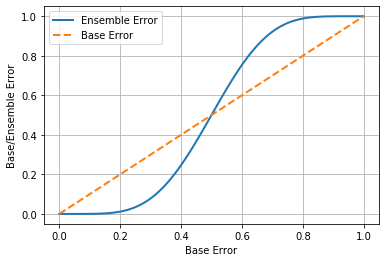

In [7]:
import matplotlib.pyplot as plt
plt.plot(error_range,ens_errors,label='Ensemble Error',linewidth=2)
plt.plot(error_range,error_range,linestyle='--',label='Base Error',linewidth=2)
plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble Error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

**Implementing A simple MajorityVoteClassifier**

In [8]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

C:\Users\imayu\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [10]:
iris=datasets.load_iris()
X,y=iris.data[50:,[1,2]],iris.target[50:]

In [11]:
print(X.shape)
print(y.shape)

(100, 2)
(100,)


In [12]:
np.unique(y)

array([1, 2])

In [13]:
le=LabelEncoder()
y=le.fit_transform(y)

In [14]:
print(y.shape)

(100,)


In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5,random_state=1)

Using the training dataset, we now will train three different classifiers—a  logistic regression classifier, a decision tree classifier, and a k-nearest neighbors classifier—and look at their individual performances via a 10-fold cross-validation  on the training dataset before we combine them into an ensemble classifier

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
import numpy as np

In [17]:
clf1=LogisticRegression(penalty='l2',C=0.001,random_state=0)
clf2=DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=0)
clf3=KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')

In [18]:
pipe1=Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3=Pipeline([['sc',StandardScaler()],['clf',clf3]])

In [19]:
clf_labels=['Logistic Regression','Decision Tree','KNN']

In [39]:
from sklearn.metrics import log_loss
print('10 fold cross-validation: \n')
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores=cross_val_score(estimator=clf,
                          X=X_train,
                          y=y_train,
                          cv=10)
    print("Score : %0.2f (+/- %0.2f) [%s]" %(scores.mean(),scores.std(),label))

10 fold cross-validation: 

Score : 0.84 (+/- 0.23) [Logistic Regression]
Score : 0.92 (+/- 0.13) [Decision Tree]


C:\Users\imayu\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\imayu\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\imayu\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\imayu\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\imayu\AppData\Local\Programs\Python\Python36\lib\si

Score : 0.94 (+/- 0.09) [KNN]


Now let's move on to the more exciting part and combine the individual classifiers for majority rule voting in our MajorityVoteClassifier

In [40]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [49]:
# create the sub models
estimators = []
model1 = LogisticRegression(penalty='l2',C=0.001)
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier(max_depth=2,criterion='entropy',random_state=0)
estimators.append(('cart', model2))
model3 = KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')
estimators.append(('KNN', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X_train, y_train, cv=10)
print(results.mean())

0.9400000000000001


C:\Users\imayu\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\imayu\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\imayu\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\imayu\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\imayu\AppData\Local\Programs\Python\Python36\lib\si

**Bagging: Building an ensemble from bootstrap samples**

However, instead of using the same training set to fit the individual classifiers in the ensemble, we draw bootstrap samples (random samples with replacement) from the initial training set, which is why bagging is also known as bootstrap aggregating

In [50]:
from sklearn.datasets import load_wine

In [52]:
data=load_wine()

In [56]:
data.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [59]:
Y=data.target
np.unique(Y)

array([0, 1, 2])

In [91]:
y=Y[Y!=0]

In [92]:
print(Y.shape)
print(y.shape)

(178,)
(119,)


In [93]:
X=data.data
print(X.shape)

(178, 13)


In [94]:
x=np.column_stack((X[:,0],X[:,10]))

In [95]:
X=x

In [96]:
X=X[Y!=0]

In [97]:
print(X.shape)

(119, 2)


In [98]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le=LabelEncoder()
y=le.fit_transform(y)

In [99]:
print(X.shape)
print(y.shape)

(119, 2)
(119,)


In [118]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.40,random_state=0)

In [119]:
from sklearn.ensemble import BaggingClassifier

In [120]:
tree=DecisionTreeClassifier(criterion='entropy',max_depth=None)

In [127]:
bag=BaggingClassifier(base_estimator=tree,
                     n_estimators=100,
                     max_samples=1,
                     max_features=1,
                     bootstrap=True,
                     bootstrap_features=False,
                     n_jobs=1,
                     random_state=1)

In [128]:
from sklearn.metrics import accuracy_score
tree=tree.fit(X_train,y_train)
y_train_pred=tree.predict(X_train)
y_test_pred=tree.predict(X_test)
tree_train=accuracy_score(y_train,y_train_pred)
tree_test=accuracy_score(y_test,y_test_pred)
print('Decision Tree train/test acuracies %.3f/%.3f' %(tree_train,tree_test))

Decision Tree train/test acuracies 1.000/0.917


In [129]:
bag=bag.fit(X_train,y_train)
y_train_pred=bag.predict(X_train)
y_test_pred=bag.predict(X_test)
bag_train=accuracy_score(y_train,y_train_pred)
bag_test=accuracy_score(y_test,y_test_pred)
print('Bagging train/test accuracies %.3f/.%3f'%(bag_train,bag_test))

Bagging train/test accuracies 0.606/.0.583333


**Adaboost Classifier**

In [131]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(base_estimator=tree,
                      n_estimators=500,
                      learning_rate=0.1,
                      random_state=0)

In [132]:
ada=ada.fit(X_train,y_train)
y_train_pred=ada.predict(X_train)
y_test_pred=ada.predict(X_test)
ada_train=accuracy_score(y_train,y_train_pred)
ada_test=accuracy_score(y_test,y_test_pred)
print('Adaboost train/test accuracies %.3f/%.3f' %(ada_train,ada_test))

Adaboost train/test accuracies 1.000/0.896
